In [2]:
# critical
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [3]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [4]:
device = torch.device("mps")

In [12]:
# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

In [19]:
dataset_mean = -0.50727963
dataset_std = 35.344276
scaling_factor = 5

### Generator

In [13]:
class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z

### Load and Generate Signals from Generator

In [14]:
signal_generator = torch.load("../models/stellar_core_collapse_signal_generator_dcgans.pt").to(device)
signal_generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

In [36]:
number_of_signals = 100

In [66]:
# generate random noise latent vectors
fixed_noise = torch.randn(number_of_signals, nz, 1, device=device)

# generate fake signals, record computing time
start_time = time.time()
with torch.no_grad():
    generated_signals = signal_generator(fixed_noise).detach().cpu()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

Execution Time: 0.4071810245513916 seconds


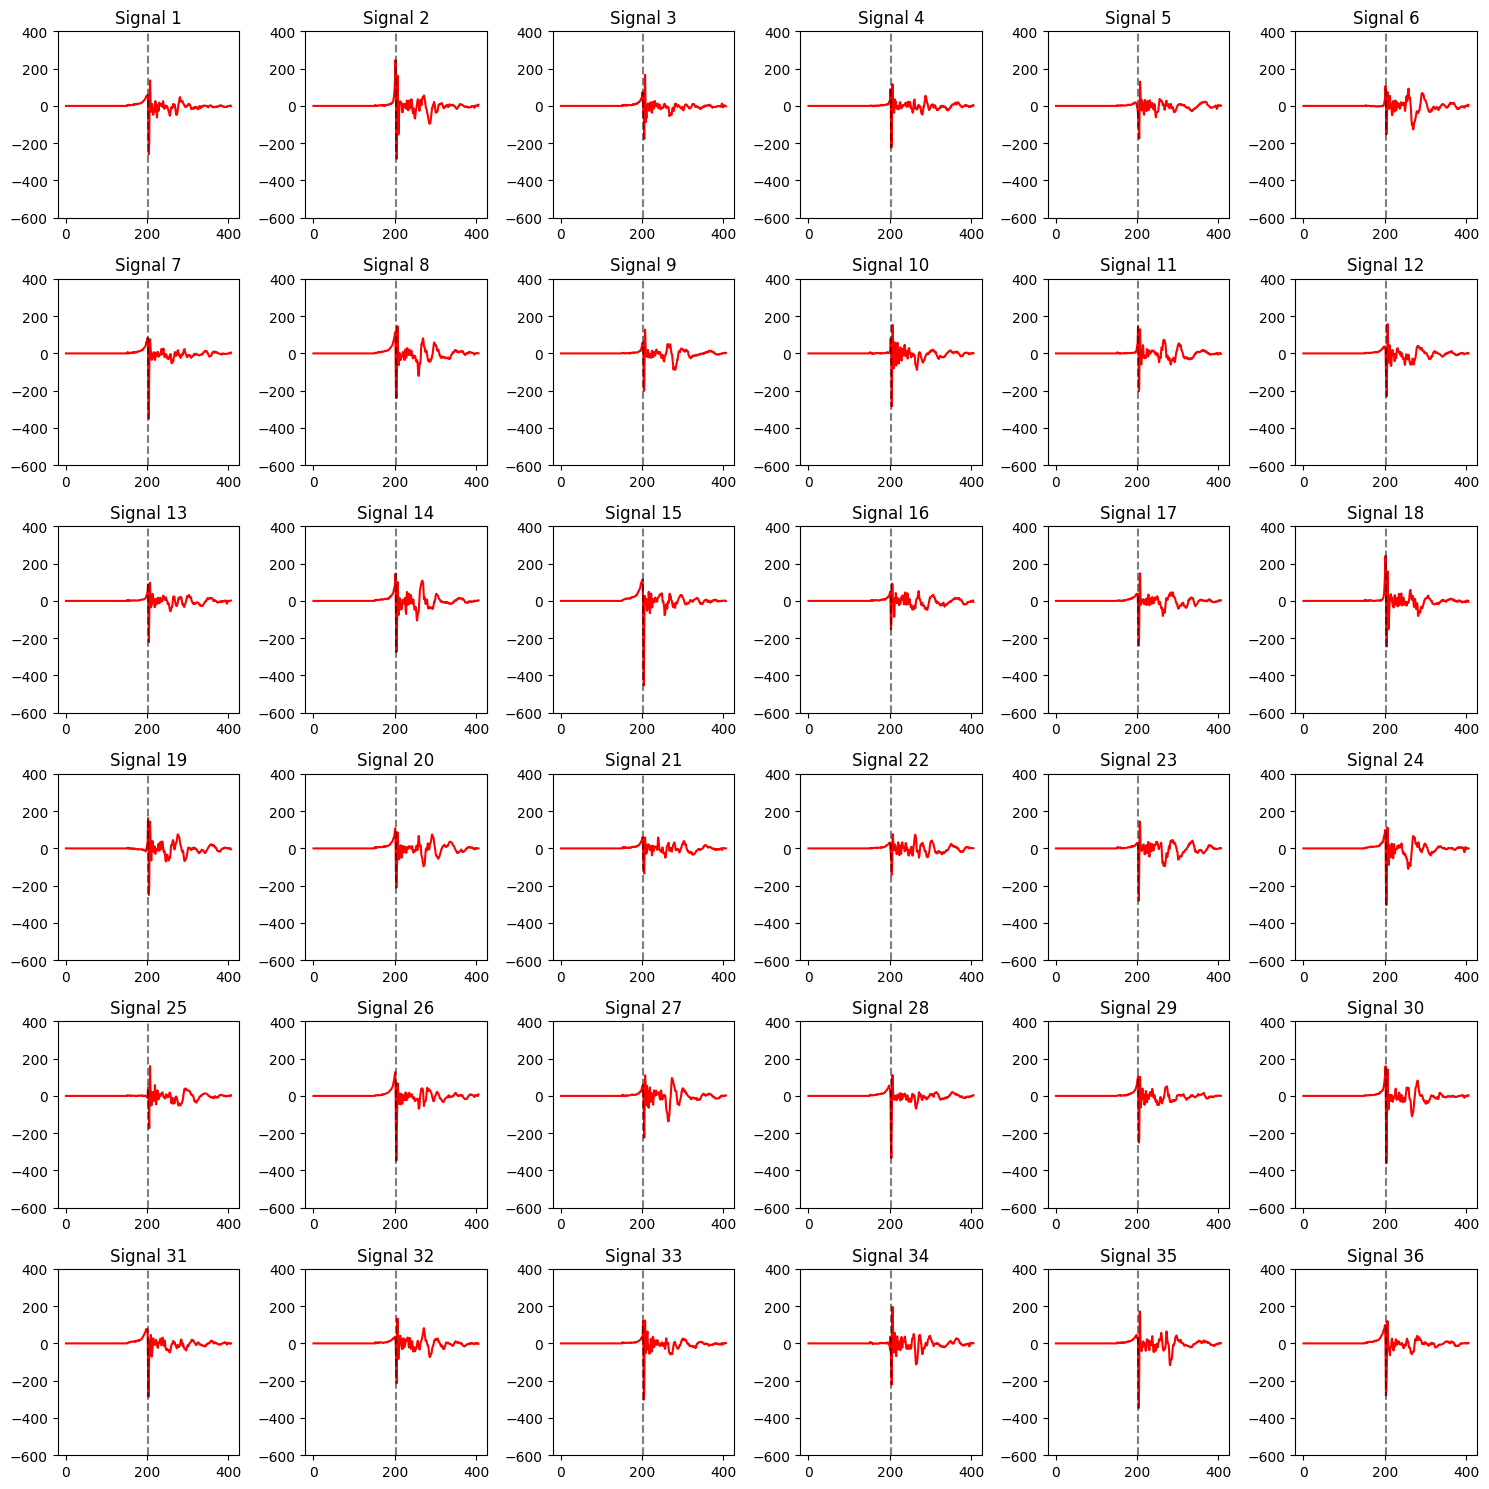

In [67]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(407)
    y = generated_signals[i, :, :].flatten()
    y = y * scaling_factor
    y = y * dataset_std + dataset_mean
    background_noise_generated = np.random.normal(0, 0, int(407-256))
    y = np.concatenate((background_noise_generated, y))
    ax.plot(x, y, color = 'red')

    ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(False)
    ax.set_ylim([-600, 400])

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Process Generated Signals

In [68]:
generated_signals_array = np.empty((407, 0))

for i in range(generated_signals.size(0)):
    y = generated_signals[i, :, :].flatten()
    y = y * scaling_factor
    y = y * dataset_std + dataset_mean
    background_noise_generated = np.random.normal(0.7490436138169922, 0.5795271002348499, int(407-256))
    y = np.concatenate((background_noise_generated, y))
    y = y.reshape(-1, 1)
    
    generated_signals_array = np.concatenate((generated_signals_array, y), axis=1)

### Save Generated Signals

In [69]:
np.savetxt('../data/output/generated_signals.csv', generated_signals_array, delimiter=',')